In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures
using Metaheuristics

In [10]:
@doc """
Inputs:
    model::EoSModel
    T = 292, 313, 333 / K
    w = wt% MEA
    loading = SO2 loading

Outputs:
    partial pressure of SO2 at given T, wt % MEA & SO2 loading

"""
function partial_SO2(model::EoSModel, T, w, loading)

    mw_MEA = 61.08
    mw_H2O = 18.01528

    wt_MEA = w
    wt_H2O = 1 - w

    x_MEA = (wt_MEA / mw_MEA) * (1 / ((wt_MEA / mw_MEA) + (wt_H2O / mw_H2O)))
    x_H2O = 1 - x_MEA
    solvrat = x_H2O / x_MEA

    x_MEA = 1 / (1 + loading + solvrat)
    x_SO2 = x_MEA * loading
    x_H2O = 1 - x_MEA - x_SO2

    x_bub = [x_MEA, x_H2O, x_SO2]

    calc = bubble_pressure(model, T, x_bub)
    pvap = calc[1]
    y_MEA = calc[4][1]
    y_H2O = calc[4][2]
    y_SO2 = calc[4][3]

    out_partial = y_SO2 * pvap
    return out_partial
end 


partial_SO2

In [3]:
model = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Sulphur Dioxide",["SO2"=>1])];
        userlocations = (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 64.066],
        epsilon = [284.78 348.39 528.21 339.89 259.90;
                   348.39 473.39 423.17 423.63 301.96;
                   528.21 423.17 407.22 358.02 302.89;
                   339.89 423.63 358.02 266.68 239.53;
                   259.90 301.96 302.89 239.53 237.54],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.1605],
        lambda_a = [6, 6, 6, 6, 6],
        lambda_r = [10.354 14.063 52.305 13.085 12.412;
                    14.063 19.871 21.230 100.00 17.354;
                    52.305 21.230 22.699 19.619 18.511;
                    13.085 100.00 19.619 17.020 16.085;
                    12.412 17.354 18.511 16.085 15.213],
        vst = [1, 1, 2, 1, 3],
        S = [0.79675, 0.22932, 0.58538, 1, 0.62547],
        n_H=[2, 0, 1, 2, 1],
        n_e=[1, 0, 2, 2, 1],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("NH2","H"),("SO2","e")) => 1011.60,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("CH2OH","H"),("SO2","e")) => 1415.90,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.60,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("H2O","H"),("SO2","e")) => 1343.90,
                              (("SO2","H"),("NH2","e")) => 1011.60,
                              (("SO2","H"),("CH2OH","e")) => 1415.90,
                              (("SO2","H"),("H2O","e")) => 1343.90,
                              (("SO2","H"),("SO2","e")) => 955.58]),
        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                        (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                        (("NH2","H"),("H2O","e")) => 22.450e-30,
                        (("NH2","H"),("SO2","e")) => 345.890e-30,
                        (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                        (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                        (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                        (("CH2OH","H"),("SO2","e")) => 303.270e-30,
                        (("H2O","H"),("NH2","e")) => 459.18e-30,
                        (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                        (("H2O","H"),("H2O","e")) => 101.69e-30,
                        (("H2O","H"),("SO2","e")) => 353.41e-30,
                        (("SO2","H"),("NH2","e")) => 345.890e-30,
                        (("SO2","H"),("CH2OH","e")) => 303.270e-30,
                        (("SO2","H"),("H2O","e")) => 353.41e-30,
                        (("SO2","H"),("SO2","e")) => 849.99e-30])))
                        

SAFTgammaMie{BasicIdeal} with 3 components:
 "MEA": "NH2" => 1, "CH2" => 1, "CH2OH" => 1
 "Water": "H2O" => 1
 "Sulphur Dioxide": "SO2" => 1
Group Type: SAFTgammaMie
Contains parameters: segment, shapefactor, lambda_a, lambda_r, sigma, epsilon, epsilon_assoc, bondvol

In [4]:
toestimate = [
    Dict(
        :param => :epsilon,
        :indices => (1,5),
        :symmetric => true,
        :lower => 250.00,
        :upper => 800.00,
        :guess => 259.90,
    )
    # Dict(
    #     :param => :epsilon_assoc,
    #     :indices => 6,
    #     :cross_assoc => false,
    #     :lower => 800.00,
    #     :upper => 3500.00,
    #     :guess => 1100.00,
    # ),
    # Dict(
    #     :param => :epsilon_assoc,
    #     :indices => 7,
    #     :cross_assoc => false,
    #     :lower => 800.00,
    #     :upper => 3500.00,
    #     :guess => 1100.00,
    # ),
    # Dict(
    #     :param => :bondvol,
    #     :indices => 6,
    #     :cross_assoc => false,
    #     :lower => 20.00e-30,
    #     :upper => 1000e-30,
    #     :guess => 3.4589e-28,
    # ),
    # Dict(
    #     :param => :bondvol,
    #     :indices => 7,
    #     :cross_assoc => false,
    #     :lower => 20.00e-30,
    #     :upper => 1000e-30,
    #     :guess => 3.4589e-28,
    # )
]

1-element Vector{Dict{Symbol, Any}}:
 Dict(:symmetric => true, :upper => 800.0, :param => :epsilon, :indices => (1, 5), :guess => 259.9, :lower => 250.0)

In [8]:
error(pred,exp) = abs(pred-exp)
estimator,objective,initial,upper,lower = Estimation(model,toestimate,["SO2_EXP_All_Data.csv"], [:vrmodel], error)
method = ECA(;options=Options(iterations=1000));

In [11]:
params, model = optimize(objective, estimator, method);
println(params)

[425.532819202829]


AssocParam{Float64}(["NH2", "CH2", "CH2OH", "H2O", "SO2"]) with 16 values:
("NH2", "e") >=< ("NH2", "H"): 1070.8
("NH2", "e") >=< ("CH2OH", "H"): 2403.78
("NH2", "H") >=< ("CH2OH", "e"): 629.88
("NH2", "e") >=< ("H2O", "H"): 1877.5
("NH2", "H") >=< ("H2O", "e"): 1364.4
("NH2", "e") >=< ("SO2", "H"): 1011.6
("NH2", "H") >=< ("SO2", "e"): 1011.6
("CH2OH", "e") >=< ("CH2OH", "H"): 2097.9
("CH2OH", "e") >=< ("H2O", "H"): 2000.6
("CH2OH", "H") >=< ("H2O", "e"): 600.0
("CH2OH", "e") >=< ("SO2", "H"): 1415.9
("CH2OH", "H") >=< ("SO2", "e"): 1415.9
("H2O", "e") >=< ("H2O", "H"): 1985.4
("H2O", "e") >=< ("SO2", "H"): 1343.9
("H2O", "H") >=< ("SO2", "e"): 1343.9
("SO2", "e") >=< ("SO2", "H"): 955.58

In [12]:
data1 = CSV.read("SO2_EXP_0.1wt.csv", DataFrame; header=false)
data2 = CSV.read("SO2_EXP_0.2wt.csv", DataFrame; header=false)
data3 = CSV.read("SO2_EXP_0.3wt.csv", DataFrame; header=false)
data4 = CSV.read("SO2_EXP_0.4wt.csv", DataFrame; header=false)
data5 = CSV.read("SO2_EXP_0.5wt.csv", DataFrame; header=false)

data1 .= convert.(Float64, data1)
data2 .= convert.(Float64, data2)
data3 .= convert.(Float64, data3)
data4 .= convert.(Float64, data4)
data5 .= convert.(Float64, data5);

#Data is in the order temp, partial pressure, wtMEA, Loading SO2

In [13]:
wt_MEA = [0.1, 0.2, 0.3, 0.4, 0.5]
wt_H2O = 1 .- wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA ./ mw_MEA) .* (1 ./ ((wt_MEA ./ mw_MEA) .+ (wt_H2O ./ mw_H2O)))
x_H2O = 1 .- x_MEA
solvrat = x_H2O ./ x_MEA



5-element Vector{Float64}:
 30.514096922168292
 13.56182085429702
  7.911062165006595
  5.085682820361383
  3.3904552135742545

In [14]:

load = LinRange(0, 0.5, 100) #these are the ratio of SO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
x_MEA = zeros(N, 5)
x_H2O = zeros(N, 5)
x_SO2 = zeros(N, 5)
z = zeros(N, 15)

# calculate the new liquid compositions at these loadings
for i in 1:5
    x_MEA[:,i] = 1 ./ (1 .+ load .+ solvrat[i])
    x_SO2[:,i] = x_MEA[:,i] .* load
    x_H2O[:,i] = 1 .- x_MEA[:,i] .- x_SO2[:,i]
    ind = 3*(i-1) + 1
    z[:, ind] = x_MEA[:,i]
    z[:, ind + 1] = x_H2O[:,i]
    z[:, ind + 2] = x_SO2[:,i]
end

# each 3 columns represents the composition under loading at a different MEA wt in solution

In [15]:

T = [293, 313, 333]

pvap1 = zeros(N, 3)
y1 = zeros(N, 3, 3)
partial1 = zeros(N, 3)

pvap2 = zeros(N, 3)
y2 = zeros(N, 3, 3)
partial2 = zeros(N, 3)

pvap3 = zeros(N, 3)
y3 = zeros(N, 3, 3)
partial3 = zeros(N, 3)

pvap4 = zeros(N, 3)
y4 = zeros(N, 3, 3)
partial4 = zeros(N, 3)

pvap5 = zeros(N, 3)
y5 = zeros(N, 3, 3)
partial5 = zeros(N, 3)

for j in 1:3
        
    for i in 1:N

        # ------------- Wt = 0.1 ----------------#
        x_bub = z[i, 1:3]
        calc = bubble_pressure(model, T[j], x_bub)
        pvap1[i, j] = calc[1]
        y1[i, 1, j] = calc[4][1]
        y1[i, 2, j] = calc[4][2]
        y1[i, 3, j] = calc[4][3]

        # ------------- Wt = 0.2 ----------------#
        x_bub = z[i, 4:6]
        calc = bubble_pressure(model, T[j], x_bub)
        pvap2[i, j] = calc[1]
        y2[i, 1, j] = calc[4][1]
        y2[i, 2, j] = calc[4][2]
        y2[i, 3, j] = calc[4][3]

        # ------------- Wt = 0.3 ----------------#
        x_bub = z[i, 7:9]
        calc = bubble_pressure(model, T[j], x_bub)
        pvap3[i, j] = calc[1]
        y3[i, 1, j] = calc[4][1]
        y3[i, 2, j] = calc[4][2]
        y3[i, 3, j] = calc[4][3]

        # ------------- Wt = 0.4 ----------------#
        x_bub = z[i, 10:12]
        calc = bubble_pressure(model, T[j], x_bub)
        pvap4[i, j] = calc[1]
        y4[i, 1, j] = calc[4][1]
        y4[i, 2, j] = calc[4][2]
        y4[i, 3, j] = calc[4][3]

        # ------------- Wt = 0.5 ----------------#
        x_bub = z[i, 13:15]
        calc = bubble_pressure(model, T[j], x_bub)
        pvap5[i, j] = calc[1]
        y5[i, 1, j] = calc[4][1]
        y5[i, 2, j] = calc[4][2]
        y5[i, 3, j] = calc[4][3]

    end

end

# --------------- Wt = 0.1 ------------------ #
partial1T1 = pvap1[2:100, 1] .* y5[2:100, 3, 1]
partial1T2 = pvap1[2:100, 2] .* y5[2:100, 3, 2]
partial1T3 = pvap1[2:100, 3] .* y5[2:100, 3, 3]

# --------------- Wt = 0.2 ------------------ #
partial2T1 = pvap2[2:100, 1] .* y5[2:100, 3, 1]
partial2T2 = pvap2[2:100, 2] .* y5[2:100, 3, 2]
partial2T3 = pvap2[2:100, 3] .* y5[2:100, 3, 3]

# --------------- Wt = 0.3 ------------------ #
partial3T1 = pvap3[2:100, 1] .* y5[2:100, 3, 1]
partial3T2 = pvap3[2:100, 2] .* y5[2:100, 3, 2]
partial3T3 = pvap3[2:100, 3] .* y5[2:100, 3, 3]

# --------------- Wt = 0.4 ------------------ #
partial4T1 = pvap4[2:100, 1] .* y5[2:100, 3, 1]
partial4T2 = pvap4[2:100, 2] .* y5[2:100, 3, 2]
partial4T3 = pvap4[2:100, 3] .* y5[2:100, 3, 3]

# --------------- Wt = 0.5 ------------------ #
partial5T1 = pvap5[2:100, 1] .* y5[2:100, 3, 1]
partial5T2 = pvap5[2:100, 2] .* y5[2:100, 3, 2]
partial5T3 = pvap5[2:100, 3] .* y5[2:100, 3, 3]


loadfil = load[2:100];

#### Wt = 0.1

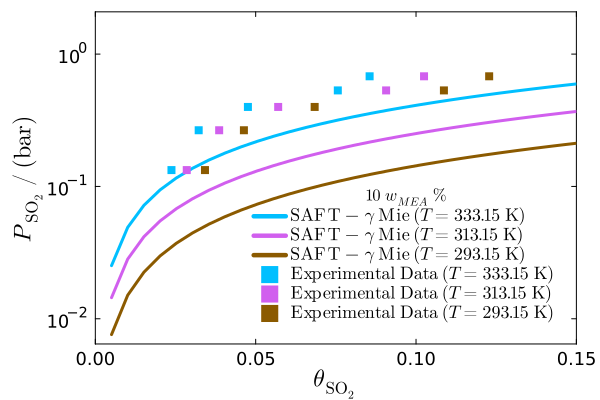

In [61]:
plt = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legend_background_color = :transparent,
            legendtitle = L"10 \ w_{MEA} \ \%",
            left_margin = 4mm,
            right_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.15))

plot!(plt, loadfil, partial1T3./1e5,
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 333.15 \ \mathrm{K})")

plot!(plt, loadfil, partial1T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 313.15 \ \mathrm{K})")

plot!(plt, loadfil, partial1T1./1e5, 
      color = "orange4", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 293.15 \ \mathrm{K})")

plot!(plt, data1[11:15,4], data1[11:15, 2]./1e5, 
      seriestype = :scatter, 
      color = "deepskyblue1", 
      markerstrokecolor = "deepskyblue1",
      marker = :square, 
      markerstrokewidth = 1,
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 333.15 \ \mathrm{K})")

plot!(plt, data1[6:10,4], data1[6:10, 2]./1e5, 
      seriestype = :scatter, 
      color = "mediumorchid2", 
      markerstrokecolor = "mediumorchid2",
      marker = :square,
      markerstrokewidth = 1, 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 313.15 \ \mathrm{K})")

plot!(plt, data1[1:5,4], data1[1:5, 2]./1e5, 
      seriestype = :scatter, 
      color = "orange4", 
      markerstrokecolor = "orange4", 
      line = (:scatter, 0.4), 
      marker = :square,
      markerstrokewidth = 1,
      label = L"\mathrm{Experimental \ Data} \ (T = 293.15 \ \mathrm{K})")

xlabel!(plt, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt, L"P_{\mathrm{SO_2}} \ / \ \mathrm{(bar)}")

#savefig(plt, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_10%MEA.png")

#### Wt = 0.2

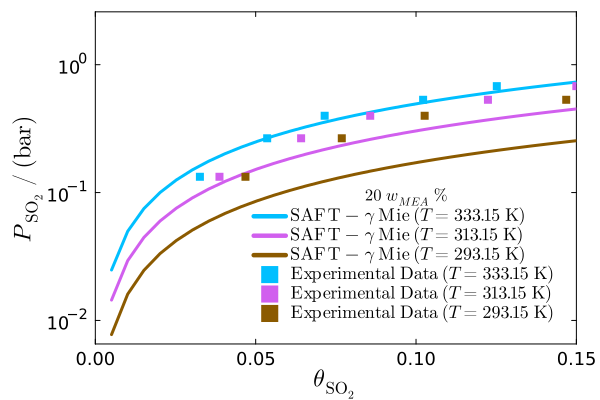

In [55]:
plt2 = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legend_background_color = :transparent,
            legendtitle = L"20 \ w_{MEA} \ \%",
            left_margin = 4mm,
            right_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.15))

plot!(plt2, loadfil, partial2T3./1e5, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 333.15 \ \mathrm{K})")

plot!(plt2, loadfil, partial2T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 313.15 \ \mathrm{K})")

plot!(plt2, loadfil, partial2T1./1e5, 
      color = "orange4", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 293.15 \ \mathrm{K})")

plot!(plt2, data2[11:15,4], data2[11:15, 2]./1e5, 
      seriestype = :scatter, 
      color = "deepskyblue1", 
      marker = :square,
      markerstrokecolor = "deepskyblue1", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 333.15 \ \mathrm{K})")

plot!(plt2, data2[6:10,4], data2[6:10, 2]./1e5, 
      seriestype = :scatter, 
      color = "mediumorchid2", 
      marker = :square,
      markerstrokecolor = "mediumorchid2", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 313.15 \ \mathrm{K})")

plot!(plt2, data2[1:5,4], data2[1:5, 2]./1e5, 
      seriestype = :scatter, 
      color = "orange4", 
      marker = :square,
      markerstrokecolor = "orange4", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 293.15 \ \mathrm{K})")


xlabel!(plt2, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt2, L"P_{\mathrm{SO_2}} \ / \ \mathrm{(bar)}")

#savefig(plt2, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_20%MEA.png")


#### Wt = 0.3

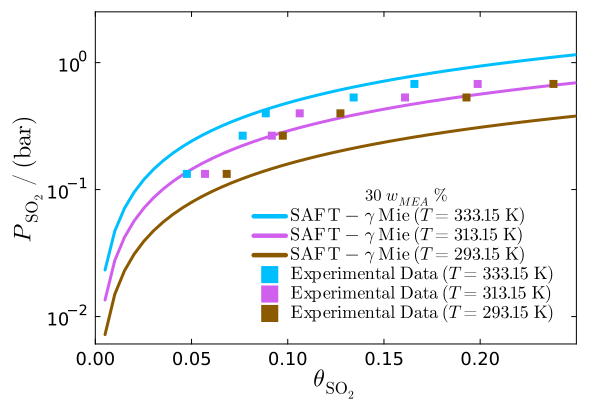

In [56]:
plt3 = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legend_background_color = :transparent,
            legendtitle = L"30 \ w_{MEA} \ \%",
            left_margin = 4mm,
            right_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.25))

plot!(plt3, loadfil, partial3T3./1e5, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 333.15 \ \mathrm{K})")

plot!(plt3, loadfil, partial3T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 313.15 \ \mathrm{K})")

plot!(plt3, loadfil, partial3T1./1e5, 
      color = "orange4", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 293.15 \ \mathrm{K})")

plot!(plt3, data3[11:15,4], data3[11:15, 2]./1e5, 
      seriestype = :scatter, 
      color = "deepskyblue1", 
      markerstrokecolor = "deepskyblue1",
      marker = :square, 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 333.15 \ \mathrm{K})")

plot!(plt3, data3[6:10,4], data3[6:10, 2]./1e5, 
      seriestype = :scatter, 
      color = "mediumorchid2", 
      markerstrokecolor = "mediumorchid2", 
      marker = :square,
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 313.15 \ \mathrm{K})")

plot!(plt3, data3[1:5,4], data3[1:5, 2]./1e5, 
      seriestype = :scatter, 
      color = "orange4", 
      markerstrokecolor = "orange4", 
      marker = :square,
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 293.15 \ \mathrm{K})")

xlabel!(plt3, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt3, L"P_{\mathrm{SO_2}} \ / \ \mathrm{(bar)}")
#savefig(plt, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_30%MEA.png")

#### Wt = 0.4

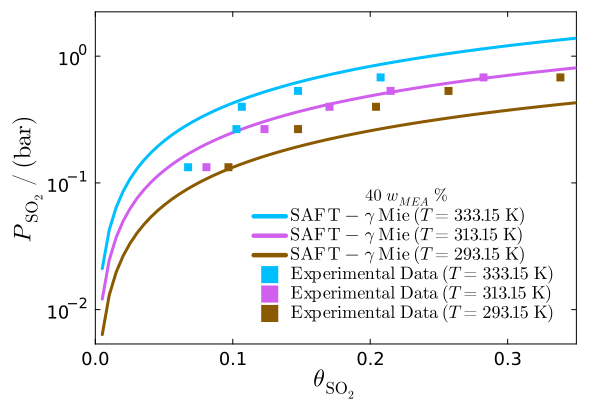

In [57]:
plt4 = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legend_background_color = :transparent,
            legendtitle = L"40 \ w_{MEA} \ \%",
            left_margin = 4mm,
            right_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.35))

plot!(plt4, loadfil, partial4T3./1e5, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 333.15 \ \mathrm{K})")

plot!(plt4, loadfil, partial4T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 313.15 \ \mathrm{K})")

plot!(plt4, loadfil, partial4T1./1e5, 
      color = "orange4", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 293.15 \ \mathrm{K})")

plot!(plt4, data4[11:15,4], data4[11:15, 2]./1e5, 
      seriestype = :scatter, 
      color = "deepskyblue1",
      marker = :square, 
      markerstrokecolor = "deepskyblue1", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 333.15 \ \mathrm{K})")


plot!(plt4, data4[6:10,4], data4[6:10, 2]./1e5, 
      seriestype = :scatter, 
      color = "mediumorchid2", 
      marker = :square, 
      markerstrokecolor = "mediumorchid2", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 313.15 \ \mathrm{K})")


plot!(plt4, data4[1:5,4], data4[1:5, 2]./1e5, 
      seriestype = :scatter, 
      color = "orange4", 
      marker = :square, 
      markerstrokecolor = "orange4", 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 293.15 \ \mathrm{K})")

xlabel!(plt4, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt4, L"P_{\mathrm{SO_2}} \ / \ \mathrm{(bar)}")

#savefig(plt4, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_40%MEA.png")

#### Wt = 0.5

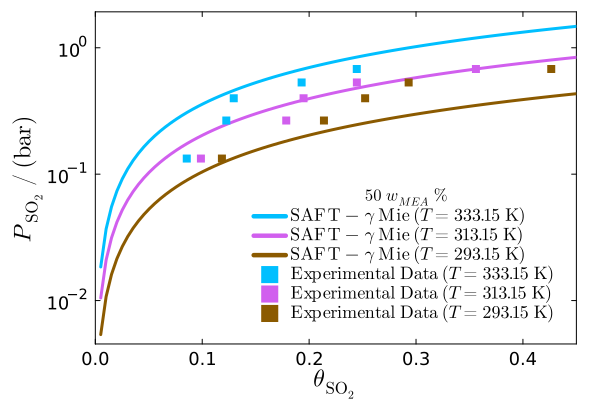

In [58]:
plt5 = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legend_background_color = :transparent,
            legendtitle = L"50 \ w_{MEA} \ \%",
            left_margin = 4mm,
            right_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.45))

plot!(plt5, loadfil, partial5T3./1e5, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 333.15 \ \mathrm{K})")

plot!(plt5, loadfil, partial5T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 313.15 \ \mathrm{K})")

plot!(plt5, loadfil, partial5T1./1e5, 
      color = "orange4", 
      line = (:path, 3), 
      label = L"\mathrm{SAFT-\gamma \ Mie} \ (T = 293.15 \ \mathrm{K})")

plot!(plt5, data5[11:15,4], data5[11:15, 2]./1e5, 
      seriestype = :scatter, 
      color = "deepskyblue1", 
      markerstrokecolor = "deepskyblue1",
      marker = :square, 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 333.15 \ \mathrm{K})")

plot!(plt5, data5[6:10,4], data5[6:10, 2]./1e5, 
      seriestype = :scatter, 
      color = "mediumorchid2", 
      markerstrokecolor = "mediumorchid2",
      marker = :square, 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 313.15 \ \mathrm{K})")


plot!(plt5, data5[1:5,4], data5[1:5, 2]./1e5, 
      seriestype = :scatter, 
      color = "orange4", 
      markerstrokecolor = "orange4",
      marker = :square, 
      line = (:scatter, 0.4), 
      label = L"\mathrm{Experimental \ Data} \ (T = 293.15 \ \mathrm{K})")

xlabel!(plt5, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt5, L"P_{\mathrm{SO_2}} \ / \ \mathrm{(bar)}")

#savefig(plt5, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_50%MEA.png")

In [63]:
plt6 = plot(
    plt, plt2, plt3, plt4, plt5,
    layout = (3, 2),
    size = (1200, 1200)
)

savefig(plt6, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_combined.png")

"C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures_Formatted\\Param_Estimation\\Epsilon_ij_425.5328\\p_SO2_combined.png"

In [100]:
function error_calc(model, data)
    
    N       = size(data)[1]
    T       = data[:, 1]
    w       = data[:, 2]
    loading = data[:, 3]

    partial_pred = zeros(N, 1)
    abs_diff = zeros(N, 1)
    exp_partial_pressure = data[:, 4]
    for i in 1:N
        partial_pred[i] = partial_SO2(model, T[i], w[i], loading[i])
        abs_diff[i] = abs(partial_pred[i] - exp_partial_pressure[i])
    end
    accum_abs_diff = sum(abs_diff)
    accum_abs_diff2 = sum(abs_diff./exp_partial_pressure)
    apd = accum_abs_diff2 * (100/N)
    return apd
end

error_calc (generic function with 1 method)

In [106]:
function get_df(csv_str)
df = CSV.read(csv_str, DataFrame)
    df_filt = df[3:end, :]
    for i in 1:size(df_filt)[2]
        df_filt[!, i] .= parse.(Float64, df_filt[!, i])
    end 
    return df_filt
end

get_df (generic function with 1 method)

In [108]:
df = get_df("SO2_EXP_All_Data.csv")
apd = error_calc(model, df)
print(apd)

36.66429289247637